In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import numpy_groupies as npg

import scipy as sp
import scipy.signal
from skimage.feature import blob_dog, blob_log, blob_doh

import itertools
import string
import pickle
import glob
import os
import re 

import tqdm.notebook as tqdm

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utils.pac import morph_cohort_pac_heatmap, PacSignificanceFunctor, morph_electrode_counter, compute_noise_with_notch
from utils.surf import create_adjacency, create_distance_matrix, convert_matrix_indices
from utils.io import load_mop, load_electrodes, load_montage, read_seeg_parcel_names, fix_mop, is_bipolar
from utils.vis import FlatSurface
from utils.vis_3d import BrainSurface
from utils.stats import bootstrap_statistic, nanpearson, corr_distance
from utils.fooof_utils import get_foofed_spectrum_chanwise
from utils.pyutils import convert_to_array, get_subsystem, reorder
from utils.plot import draw_four_views
from utils.colors import okabe, ripples_blue, ripples_orange, ripples_red
from utils.frequency_community import FrequencyCommunity
from utils.surf import smooth_adjacent_values
from utils.colornoise import powerlaw_psd_gaussian

from crosspy.core.autocorrelation import get_length_by_cdf

%config InlineBackend.figure_format = 'jpg'

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
def load_psd_data(subject_number):
    return pickle.load(open(f'meso_data/psd_statistics/sub-{subject_number}_spectrum.pickle', 'rb'))

In [4]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

In [5]:
n_cortical = 400
lags_cycles = np.arange(200)/10

In [6]:
data_root = 'L://nttk-data3//palva//SEEG_project_backup//SEEG_redux_BIDS//'

ez_data = pd.read_csv('meso_data/202001_SEEG_ripple_Cohort_Contacts.csv', sep=';', header=None)
ez_grouped = ez_data.groupby(0)

df = pd.read_csv('meso_data/convert_results.csv')
df_num_idx = df.set_index('subject_number')

In [7]:
pial_rh_fname = 'meso_data/fsaverage6/surf/rh.pial'
inflated_rh_fname = 'meso_data/fsaverage6/surf/rh.inflated'
annot_rh_fname = f'meso_data/fsaverage6/label/rh.Schaefer2018_{n_cortical}Parcels_17Networks_order.annot'

pial_lh_fname = 'meso_data/fsaverage6/surf/lh.pial'
inflated_lh_fname = 'meso_data/fsaverage6/surf/lh.inflated'
annot_lh_fname = f'meso_data/fsaverage6/label/lh.Schaefer2018_{n_cortical}Parcels_17Networks_order.annot'

In [8]:
seeg_parcel_names = read_seeg_parcel_names(n_cortical)
unk_idx = [idx for (idx, n) in enumerate(seeg_parcel_names[-402:]) if ('unknown' in n.lower()) or ('background' in n.lower())]

In [9]:
adjacency_lh_orig = create_adjacency(inflated_lh_fname, annot_lh_fname, offset=0, n_parcels=n_cortical)
adjacency_matrix_lh = convert_matrix_indices(adjacency_lh_orig, annot_lh_fname, np.delete(seeg_parcel_names[-402:], unk_idx), offset=0)

adjacency_rh_orig = create_adjacency(inflated_rh_fname, annot_rh_fname, offset=0, n_parcels=n_cortical)
adjacency_matrix_rh = convert_matrix_indices(adjacency_rh_orig, annot_rh_fname, np.delete(seeg_parcel_names[-402:], unk_idx), offset=n_cortical//2)

adjacency_matrix = adjacency_matrix_lh |  adjacency_matrix_rh

In [10]:
res_path = os.path.join('meso_data', 'pac_signal_frequency_7.5', 'pac_sub*.pickle')
res_files = glob.glob(res_path)

print(len(res_files))

68


In [11]:
bad_subjects = ['02', # weird mop
                '06',
                '40',
                '42',
                '57',
                '60',# too short
               ] 

In [12]:
meta_data_subjects = pickle.load(open('meso_data/meta_data_subjects.pickle', 'rb'))

In [13]:
cohort_pacf_lifetime = list()
noise_channelwise_lengths = list()

cohort_ez_chans = list()
data_parcels = list()

cohort_psd_foofed = list()

for fname in res_files:
    base_name = os.path.split(fname)[~0]
    subj_num = re.findall(r'\d+', base_name)[0]
    subj_name = df_num_idx.loc[int(subj_num)]['name']
    
    if subj_num in  bad_subjects:
        print('passing', subj_num)
        continue
    
    subj_ez = ez_grouped.get_group(subj_name).set_index(1)
    
    subj_montage = meta_data_subjects[subj_num]['montage']
    bipolar_mask = subj_montage['name'].apply(is_bipolar)
    subj_montage = subj_montage[bipolar_mask]
    subj_chans = subj_montage['name'].tolist()
    
    subj_mop = fix_mop(meta_data_subjects[subj_num]['mop'], bipolar_mask)
    subj_parcels = subj_mop['parcel_assign']
    
    subj_res = pickle.load(open(fname, 'rb'))
    f_vals = np.array(subj_res['f_vals'])
    
    if subj_res['data_pac'].shape[1] != subj_montage.shape[0] or subj_num in bad_subjects:
        print('passing', subj_num)
        continue
        
    if np.array_equal(subj_chans, subj_mop['channel_names']) == False:
        index_mapper = [subj_chans.index(n) for n in subj_mop['channel_names']]
        subj_parcels = subj_parcels[index_mapper]

    subj_statistics = load_psd_data(subj_num)
    
    ez_chans = [subj_ez.loc[ch_name][2] != 0 for ch_name in subj_montage['name']]
    
    subj_lengths_channelwise = np.array([np.apply_along_axis(lambda arr: get_length_by_cdf(arr, lags_cycles, 0.9), 1, pac)
                                        for pac in subj_res['data_pac']])
    
    subj_noise_lengths_channelwise = np.array([np.apply_along_axis(lambda arr: get_length_by_cdf(arr, lags_cycles, 0.9), 1, pac) 
                                        for pac in subj_res['noise_pac']])
    
    
    subj_psd_foofed = get_foofed_spectrum_chanwise(subj_statistics['psd_frequencies'], subj_statistics['psd'], freqs_to_map=f_vals)
    
    cohort_pacf_lifetime.append(subj_lengths_channelwise)
    noise_channelwise_lengths.append(subj_noise_lengths_channelwise)
    
    cohort_ez_chans.append(ez_chans)
    
    data_parcels.append(subj_parcels)
    
    cohort_psd_foofed.append(subj_psd_foofed)

passing 02
passing 06


d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\crosspy-0.0.1b0-py3.7.egg\crosspy\core\autocorrelation.py:27: RuntimeWarning: invalid value encountered in true_divide


passing 19
passing 40
passing 42
passing 57
passing 60


In [14]:
data_parcels = convert_to_array(data_parcels)
cohort_pacf_lifetime = convert_to_array(cohort_pacf_lifetime)
noise_channelwise_lengths = convert_to_array(noise_channelwise_lengths)
cohort_psd_foofed = convert_to_array(cohort_psd_foofed)

In [15]:
noise_level = np.percentile(np.concatenate(noise_channelwise_lengths, axis=-1), 99, axis=-1)
noise_with_notch = compute_noise_with_notch(noise_level)
meg_noise_with_notch = compute_noise_with_notch(noise_level, notch_manual=3.2)
meg_noise_with_notch[61:] = 3.3

In [16]:
yeo7_to_17_mapping_fname  = r'L:\nttk_palva\Utilities\parcellations\parc_info_old\mapping_7_17_old\7_to_17_400.csv'
yeo7_to_17_mapping_df  = pd.read_csv(yeo7_to_17_mapping_fname, header=None, sep=';')
yeo17_orig_ch_names = [n.split('-')[0] for n in yeo7_to_17_mapping_df[2]]

In [17]:
meg_pac_results = pickle.load(open('meso_data/meg_pac_results_full.pickle', 'rb'))

In [18]:
fsaverage_path = r'L:\nttk-data2\palva\Common repos\_fsaverage\fsaverage'

s_meg = FlatSurface(fsaverage_path, parcellation=f'Schaefer2018_{n_cortical}Parcels_17Networks')
meg_parcels_annot = s_meg.annotations['lh']['parcel_names'][1:] + s_meg.annotations['rh']['parcel_names'][1:]
meg_parcel_names = [n[:-3] for n in meg_pac_results['parcel_names']]

In [19]:
meg_path = r'L:\nttk-data3\palva\Vlad\pac_meg_controls_rs_omega_7.5_signal_freq'
meg_files = glob.glob(meg_path + '\\*_parcels.pickle')

meg_psd_foofed = np.zeros((len(meg_files), len(f_vals), 400))

for subj_idx, fname in enumerate(tqdm.tqdm(meg_files)):
    subj_code = os.path.split(fname)[~0].split('_')[0]
    subj_psd_fname = os.path.join(meg_path, f'{subj_code}_psd.pickle')
    
    subj_fdata = pickle.load(open(fname, 'rb'))
    
    subj_psd_fdata = pickle.load(open(subj_psd_fname, 'rb'))
    
    subj_psd_foofed = get_foofed_spectrum_chanwise(subj_psd_fdata['frequencies'], subj_psd_fdata['psd'].mean(axis=0).T, freqs_to_map=f_vals)
    
    meg_psd_foofed[subj_idx] = subj_psd_foofed

  0%|          | 0/54 [00:00<?, ?it/s]

## Analysis with parcels

In [20]:
cohort_seeg_pac_values = morph_cohort_pac_heatmap(data_parcels, cohort_pacf_lifetime, n_parcels=n_cortical+93)
cohort_seeg_pac_significant = morph_cohort_pac_heatmap(data_parcels, cohort_pacf_lifetime, n_parcels=n_cortical+93, 
                                                functor=PacSignificanceFunctor(noise_channelwise_lengths, correct_notch=True, significance_level=99))

cohort_seeg_pac_known = np.delete(cohort_seeg_pac_values[:, -402:], unk_idx, axis=1)
cohort_seeg_pac_known_significant = np.delete(cohort_seeg_pac_significant[:, -402:], unk_idx, axis=1)

seeg_pac_values = np.nanmean(cohort_seeg_pac_values, axis=0)
seeg_pac_significant = np.nanmean(cohort_seeg_pac_significant, axis=0)

known_pac_significant = np.delete(seeg_pac_significant[-402:], unk_idx, axis=0)
known_pac_values = np.delete(seeg_pac_values[-402:], unk_idx, axis=0)

C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == "__main__":


In [21]:
morphed_counter = np.array([morph_electrode_counter(subj_mop, 493) for subj_mop in data_parcels])
morphed_counter = np.nansum(morphed_counter, axis=0)

counter_known = np.delete(morphed_counter[-402:], [0,201])

In [22]:
known_pac_values_smoothed = np.array([smooth_adjacent_values(vals, counter_known, adjacency_matrix) for vals in known_pac_values.T]).T
known_pac_sign_smoothed = np.array([smooth_adjacent_values(vals, counter_known, adjacency_matrix) for vals in known_pac_significant.T]).T

In [23]:
seeg_ratio_mean_multilevel = np.zeros((3, 81))
seeg_ratio_ci_multilevel = np.zeros((3, 2, 81))

for ratio_idx, ratio in enumerate([90, 95, 99]):
    cohort_seeg_pac_significant = morph_cohort_pac_heatmap(data_parcels, cohort_pacf_lifetime, n_parcels=n_cortical+93, 
                                                    functor=PacSignificanceFunctor(noise_channelwise_lengths, correct_notch=True, significance_level=ratio))

    cohort_seeg_pac_known_significant = np.delete(cohort_seeg_pac_significant[:, -402:], unk_idx, axis=1)
    
    
    sign_ratio_boot = bootstrap_statistic(cohort_seeg_pac_known_significant)
    
    seeg_ratio_mean_multilevel[ratio_idx] = np.nanmean(sign_ratio_boot, axis=(0,1))
    seeg_ratio_ci_multilevel[ratio_idx] = np.nanpercentile(np.nanmean(sign_ratio_boot, axis=1), (5,95), axis=0)

d:\Vlad\projects\seeg_mesoarchitecture\utils\stats.py:90: RuntimeWarning: Mean of empty slice
  res[i] = func_object(xp.take(arr, round_idx, axis=axis), axis=axis)


In [24]:
noise_data = powerlaw_psd_gaussian(1, size=(1000, 10000))
f_psd, pxx = sp.signal.welch(noise_data, fs=1000, nperseg=256*16)
pxx_foofed = get_foofed_spectrum_chanwise(f_psd, pxx, freqs_to_map=f_vals)

In [26]:
psd_noise_level = np.percentile(pxx_foofed, 99)
psd_sign_func = lambda x: x >= psd_noise_level

cohort_seeg_psd_significant = morph_cohort_pac_heatmap(data_parcels, cohort_psd_foofed, n_parcels=n_cortical+93, functor=psd_sign_func)
cohort_seeg_psd_known_significant = np.delete(cohort_seeg_psd_significant[:, -402:], unk_idx, axis=1)

psd_sign_ratio_boot = bootstrap_statistic(cohort_seeg_psd_known_significant)

psd_sign_ratio_mean = np.nanmean(psd_sign_ratio_boot, axis=(0,1))
psd_sign_ratio_5, psd_sign_ratio_95 = np.percentile(np.nanmean(psd_sign_ratio_boot, axis=1), (5,95), axis=0)


In [28]:
cohort_seeg_psd_values = morph_cohort_pac_heatmap(data_parcels, cohort_psd_foofed, n_parcels=n_cortical + 93)
cohort_seeg_psd_known = np.delete(cohort_seeg_psd_values[:, -402:], unk_idx, axis=1)

seeg_psd_known = np.nanmean(cohort_seeg_psd_known, axis=0)

C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [29]:
meg_pac_sign = (meg_pac_results['average_pac'] >= meg_noise_with_notch.reshape(1,-1,1)).mean(axis=0)

meg_average_pac = meg_pac_results['average_pac'].mean(axis=0)
meg_pac_reordered = reorder(meg_average_pac, meg_parcel_names, meg_parcels_annot, axis=-1)

In [30]:
meg_ratio_individual = (meg_pac_results['average_pac'] >= meg_noise_with_notch.reshape(1,-1,1))
meg_ratio_boot = bootstrap_statistic(meg_ratio_individual)

meg_ratio_mean = meg_ratio_boot.mean(axis=(0,2))
meg_ratio_mean_parcelwise = meg_ratio_boot.mean(axis=0)
meg_ratio_5, meg_ratio_95 = np.percentile(np.mean(meg_ratio_boot, axis=-1), (5,95), axis=0)

In [31]:
meg_ratio_mean_multilevel = np.zeros((3, 81))
meg_ratio_ci_multilevel = np.zeros((3, 2, 81))

for ratio_idx, ratio in enumerate([90, 95, 99]):
    r_noise_level = np.percentile(np.concatenate(noise_channelwise_lengths, axis=-1), ratio, axis=-1)
    r_noise_level[61:] = r_noise_level[:10].mean()
    r_ratio_individual = (meg_pac_results['average_pac'] >= r_noise_level.reshape(1,-1,1))
    
    r_ratio_boot = bootstrap_statistic(r_ratio_individual)
    
    meg_ratio_mean_multilevel[ratio_idx] = r_ratio_boot.mean(axis=(0,-1))
    meg_ratio_ci_multilevel[ratio_idx] = np.percentile(r_ratio_boot.mean(axis=-1), (5,95), axis=0)

In [32]:
# print('SEEG peaks: alpha {:.2f}Hz, beta {:.2f}Hz'.format(*f_vals[sp.signal.find_peaks(ratio_mean, height=0.15)[0]]))
# print('MEG peaks: alpha {:.2f}Hz, beta {:.2f}Hz'.format(*f_vals[sp.signal.find_peaks(meg_ratio_mean, height=0.15)[0]]))

print('SEEG peaks: alpha {:.2f}Hz, beta {:.2f}Hz'.format(*f_vals[sp.signal.find_peaks(seeg_ratio_mean_multilevel[0], height=0.3)[0]]))
print('MEG peaks: alpha {:.2f}Hz, beta {:.2f}Hz'.format(*f_vals[sp.signal.find_peaks(meg_ratio_mean_multilevel[0], height=0.25)[0]]))

SEEG peaks: alpha 7.84Hz, beta 14.78Hz
MEG peaks: alpha 10.51Hz, beta 20.80Hz


In [33]:
pac_val_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(known_pac_values_smoothed.T, metric=corr_distance))
psd_val_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(seeg_psd_known.T, metric=lambda *args: nanpearson(*args)[0]))

np.fill_diagonal(pac_val_similarity_freq_both, 1.0)
np.fill_diagonal(psd_val_similarity_freq_both, 1.0)

In [34]:
pac_resutls_new = pickle.load(open('meso_data/meg_pac_with_statistics_wpli.pickle', 'rb'))
psd_freqs_mapper = np.abs(pac_resutls_new['psd_frequencies'].reshape(1,-1) - np.array(pac_resutls_new['frequencies']).reshape(-1,1)).argmin(axis=-1)

In [35]:
meg_foofed = list()

for subj_spectrum in tqdm.tqdm(pac_resutls_new['psd']):
    subj_foofed = get_foofed_spectrum_chanwise(pac_resutls_new['psd_frequencies'], subj_spectrum, freqs_to_map=f_vals)
    
    meg_foofed.append(subj_foofed)
    
meg_foofed = np.array(meg_foofed)
meg_foofed_reordered_subjwise = reorder(meg_foofed, meg_parcel_names, meg_parcels_annot, axis=-1)
meg_foofed_reordered = meg_foofed_reordered_subjwise.mean(axis=0)

  0%|          | 0/54 [00:00<?, ?it/s]

In [36]:
meg_psd_significant_subjectwise = (meg_foofed_reordered_subjwise >= 0.5)
meg_psd_sign_boot = bootstrap_statistic(meg_psd_significant_subjectwise)

meg_psd_sign_mean = meg_psd_sign_boot.mean(axis=(0,-1))
meg_psd_sign_5, meg_psd_sign_95 = np.percentile(meg_psd_sign_boot.mean(axis=-1), (5,95), axis=0)


In [37]:
meg_pac_val_similarity_freq_both = 1 - sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_average_pac, metric=corr_distance))
meg_psd_val_similarity_freq_both = 1 - sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_foofed_reordered, metric=corr_distance))

meg_pac_val_corr_freq_both = 1 - sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_average_pac, metric='correlation'))


In [38]:
meg_pac_sign_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_pac_sign, metric=lambda *args: nanpearson(*args)[0]))
meg_pac_sign_similarity_freq_both[np.isnan(meg_pac_sign_similarity_freq_both)] = 0.0

meg_psd_val_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(meg_foofed_reordered, metric=lambda *args: nanpearson(*args)[0]))

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [39]:
pac_val_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(known_pac_values.T, metric=corr_distance))
pac_val_similarity_freq_smoothed_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(known_pac_values_smoothed.T, metric=corr_distance))

pac_val_corr_freq_smoothed_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(known_pac_values_smoothed.T, metric=lambda *args: nanpearson(*args)[0]))
pac_sign_similarity_freq_both = sp.spatial.distance.squareform(sp.spatial.distance.pdist(known_pac_significant.T, metric=lambda *args: nanpearson(*args)[0]))


In [40]:
### SEEG
seeg_blobs = blob_dog(1 - pac_val_similarity_freq_smoothed_both, sigma_ratio=1.25, max_sigma=5, min_sigma=1.25, threshold=0.2)
seeg_blobs = [blob for blob in seeg_blobs if (blob[0] == blob[1]) and (blob[2] > 1.25)]

seeg_frequency_communities = [FrequencyCommunity.from_blob(blob, f_vals) for blob in seeg_blobs if (blob[0] == blob[1]) and (blob[2] > 1.25)]
seeg_frequency_communities = sorted(seeg_frequency_communities, key=lambda x: x.center)

### MEG
# meg_blobs = blob_log(meg_pac_val_similarity_freq_both,  max_sigma=5, min_sigma=2, threshold=0.2)
meg_blobs = blob_dog(meg_pac_val_similarity_freq_both, sigma_ratio=1.25, max_sigma=5, min_sigma=1.25, threshold=0.2)
meg_blobs = [blob for blob in meg_blobs if (blob[0] == blob[1]) and (blob[2] > 1.25)]

meg_frequency_communities = [FrequencyCommunity.from_blob(blob, f_vals) for blob in meg_blobs]
meg_frequency_communities = sorted(meg_frequency_communities, key=lambda x: x.center)


In [41]:
parcel_cohort_idx = np.argsort(known_pac_significant[:, :62].argmax(axis=1) - np.any(np.isnan(known_pac_significant), axis=1))

meg_cohort_idx = meg_pac_sign[:60].argmax(axis=0).argsort()

In [42]:
brain_surf_lh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['lh'], surface='inflated')
brain_surf_rh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['rh'], surface='inflated')

surf_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]

brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]

In [43]:
pac_val_corr_distance = np.sqrt(1 - pac_val_corr_freq_smoothed_both)/np.sqrt(2)
meg_pac_val_corr_distance = np.sqrt(1 - meg_pac_val_corr_freq_both)/np.sqrt(2)

In [44]:
def compute_surr_freq_correlation(values, n_rounds=100):
    values_shuf = values.T.copy()

    res = np.zeros((n_rounds, values.shape[1], values.shape[1]))

    for i in range(n_rounds):
        for j in range(values.shape[1]):
            np.random.shuffle(values_shuf[j])
        
        res[i] = sp.spatial.distance.squareform(sp.spatial.distance.pdist(values_shuf, metric=lambda *args: nanpearson(*args)[0]))

    return res

In [45]:
upper_indices = np.triu_indices(81, 1)

surr_freq_corr_values = compute_surr_freq_correlation(known_pac_values_smoothed, n_rounds=1000)
surr_freq_corr_values_flat = np.array([v[upper_indices] for v in surr_freq_corr_values])
surr_freq_dist_values_flat = np.sqrt(1 - surr_freq_corr_values_flat)/np.sqrt(2)

In [46]:
surr_freq_corr_values_flat = np.array([v[upper_indices].max() for v in surr_freq_corr_values])
surr_freq_dist_values_flat = np.sqrt(1 - surr_freq_corr_values_flat)/np.sqrt(2)

(array([  2.,   5.,   2.,  16.,  20.,  58., 111., 280., 363., 143.]),
 array([0.55867765, 0.56771642, 0.57675519, 0.58579397, 0.59483274,
        0.60387151, 0.61291029, 0.62194906, 0.63098783, 0.64002661,
        0.64906538]),
 <BarContainer object of 10 artists>)

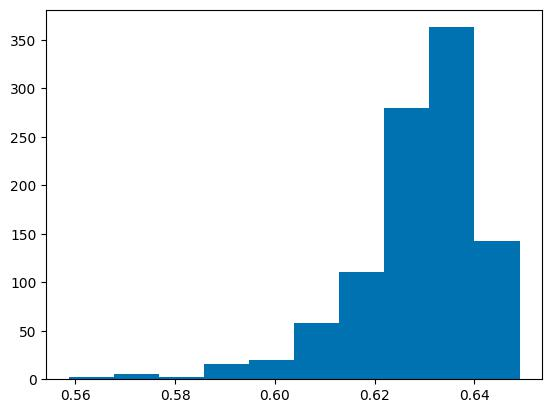

In [47]:
plt.hist(surr_freq_dist_values_flat.flatten())

In [48]:
import networkx as nx
from cdlib import algorithms

import skimage

from collections import Counter

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer'}


In [49]:
def remove_small_clusters(mask, min_size=5):
    res = np.zeros_like(mask)

    labels = skimage.measure.label(mask)
    counts = Counter(labels.flatten())
    counts.pop(0)


    for lbl, cnt in counts.items():
        if cnt >= min_size:
            res[labels == lbl] = True

    return res
    

In [50]:
def filter_out_distance_matrix(distance, threshold, freq_distance=10, min_size=5):
    distant_freqs_mask = np.abs(np.arange(81).reshape(1,-1) - np.arange(81).reshape(-1,1)) > 10
    similar_freqs_mask = distance > threshold

    similarity_mask_combined = distant_freqs_mask | similar_freqs_mask
    similarity_mask_cleared = ~remove_small_clusters(~similarity_mask_combined, min_size=min_size)

    pac_val_corr_distance_filtered = 1 - distance.copy()
    pac_val_corr_distance_filtered[similarity_mask_cleared] = 0.0

    return pac_val_corr_distance_filtered

In [51]:
distant_freqs_mask = np.abs(np.arange(81).reshape(1,-1) - np.arange(81).reshape(-1,1)) > 10
similar_freqs_mask = pac_val_corr_distance > 0.58

similarity_mask_combined = distant_freqs_mask | similar_freqs_mask
similarity_mask_cleared = ~remove_small_clusters(~similarity_mask_combined)

pac_val_corr_distance_filtered = 1 - pac_val_corr_distance.copy()
pac_val_corr_distance_filtered[similarity_mask_cleared] = 0.0

In [52]:
pac_val_corr_distance_filtered_new = filter_out_distance_matrix(pac_val_corr_distance, 0.58, 10)
meg_pac_val_corr_distance_filtered = filter_out_distance_matrix(meg_pac_val_corr_distance, 0.58, 10, min_size=10)

In [53]:
import karateclub
import cdlib
from collections import defaultdict


def danmf_custom(
    g_original: object,
    layers: tuple = (32, 8),
    pre_iterations: int = 100,
    iterations: int = 100,
    seed: int = 42,
    lamb: float = 0.01):
    """
    The procedure uses telescopic non-negative matrix factorization in order to learn a cluster memmbership distribution over nodes. The method can be used in an overlapping and non-overlapping way.
    **Supported Graph Types**
    ========== ======== ========
    Undirected Directed Weighted
    ========== ======== ========
    Yes        No       Yes
    ========== ======== ========
    :param g_original: a networkx/igraph object
    :param layers: Autoencoder layer sizes in a list of integers. Default [32, 8].
    :param pre_iterations: Number of pre-training epochs. Default 100.
    :param iterations: Number of training epochs. Default 100.
    :param seed: Random seed for weight initializations. Default 42.
    :param lamb: Regularization parameter. Default 0.01.
    :return: NodeClustering object
    :Example:
    >>> from cdlib import algorithms
    >>> import networkx as nx
    >>> G = nx.karate_club_graph()
    >>> coms = algorithms.danmf(G)
    :References:
    Ye, Fanghua, Chuan Chen, and Zibin Zheng. "Deep autoencoder-like nonnegative matrix factorization for community detection." Proceedings of the 27th ACM International Conference on Information and Knowledge Management. 2018.
    .. note:: Reference implementation: https://karateclub.readthedocs.io/
    """

    g = cdlib.utils.convert_graph_formats(g_original, nx.Graph)
    model = karateclub.DANMF(layers, pre_iterations, iterations, seed, lamb)

    mapping = {node: i for i, node in enumerate(g.nodes())}
    rev = {i: node for node, i in mapping.items()}
    H = nx.relabel_nodes(g, mapping)

    model.fit(H)
    members = model.get_memberships()

    return model

In [54]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def split_single(c):
    c_sorted = sorted(c)
    diff = np.diff(c)
    mask = diff > 1
    indices = np.where(mask)[0]

    return np.split(c_sorted, indices+1)

def split_communities(communities):
    return flatten([split_single(c) for c in communities])

def filter_small_communities(communities, significant_ratio, sign_threshold=0.05, min_size=3):
    res = [c for c in communities if (significant_ratio[c].mean() > sign_threshold) and len(c) > min_size]

    return res

In [55]:
G = nx.from_numpy_array(pac_val_corr_distance_filtered)
coms = algorithms.danmf(G, layers=[64,10], lamb=0.1)
seeg_communities = filter_small_communities(coms.communities, seeg_ratio_mean_multilevel[~0])
seeg_communities = sorted(seeg_communities, key=lambda x: f_vals[x].mean())

G = nx.from_numpy_array(meg_pac_val_corr_distance_filtered)
meg_coms = algorithms.danmf(G, layers=[64,15], lamb=0.1)
meg_communities = filter_small_communities(meg_coms.communities, meg_ratio_mean_multilevel[~0], min_size=2, sign_threshold=0.02)
meg_communities = sorted(meg_communities, key=lambda x: f_vals[x].mean())


In [56]:
np.fill_diagonal(pac_val_corr_freq_smoothed_both, 1.0)
mpl.rc('font', family='sans-serif') 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


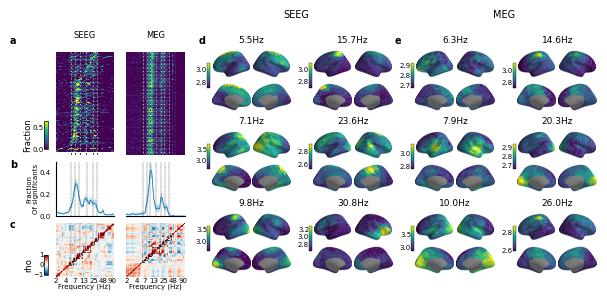

In [80]:
fig = plt.figure(figsize=(7,3))
main_spec = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1,3], wspace=0.1)

gs_0 = main_spec[0].subgridspec(3,2, hspace=0.1, height_ratios=[2,1,1])
gs_brain_cols = main_spec[1].subgridspec(nrows=3, ncols=4, hspace=0.2, wspace=0.25)

axes = np.empty((12,10), dtype=object)

axes[0,0] = fig.add_subplot(gs_0[0, 0])
axes[0,1] = fig.add_subplot(gs_0[0, 1])
axes[2,0] = fig.add_subplot(gs_0[1, 0])
axes[2,1] = fig.add_subplot(gs_0[1, 1])
axes[3,0] = fig.add_subplot(gs_0[2, 0])
axes[3,1] = fig.add_subplot(gs_0[2, 1])


for i,j in itertools.product(range(3), range(4)):
    brain_gs = gs_brain_cols[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc+2] = fig.add_subplot(brain_gs[nr,nc])
        
imh_seeg = axes[0,0].pcolormesh(f_vals, np.arange(400), known_pac_significant[parcel_cohort_idx], cmap='viridis', vmax=0.65, rasterized=True)
imh_meg = axes[0,1].pcolormesh(f_vals, np.arange(400), meg_pac_sign[:, meg_cohort_idx].T, cmap='viridis', vmax=0.65, rasterized=True)

axes[0,0].set_xscale('log')
axes[0,1].set_xscale('log')

axes[2,0].semilogx(f_vals, seeg_ratio_mean_multilevel[~0], lw=0.5)
axes[2,0].fill_between(f_vals, *seeg_ratio_ci_multilevel[~0], alpha=0.25)

axes[2,1].semilogx(f_vals, meg_ratio_mean_multilevel[~0], lw=0.5)

axes[2,1].fill_between(f_vals, *meg_ratio_ci_multilevel[~0], alpha=0.25)

cax_seeg =  inset_axes(axes[0,0],
                 width="10%",  # width = 10% of parent_bbox width
                 height="25%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(-0.2, 0.05, 0.8, 1.05),
                 bbox_transform=axes[0,0].transAxes,
                 borderpad=0,
                 )

seeg_cbar = fig.colorbar(imh_seeg, cax=cax_seeg, orientation='vertical')
seeg_cbar.outline.set_linewidth(0.5)

# for i, band_name in enumerate(['Low alpha', 'Alpha', 'High alpha', 'Beta'], start=0): 
for i in range(6):   
    for type_idx, modality, mapper, data in zip(range(2), ['SEEG', 'MEG'], 
                                [seeg_communities, meg_communities],
                                [known_pac_values, meg_pac_reordered.T]):
        row_idx = (i % 3)
        col_idx = (i // 3) + type_idx*2

        is_seeg = (modality == 'SEEG')
        indices = mapper[i]
        center_frequency = f_vals[indices].mean()

        values = np.nanmean(data[:, indices], axis=-1)
        cmap_name = 'viridis'
        norm_values = None
        
        if is_seeg:
            values = smooth_adjacent_values(values, counter_known, adjacency_matrix)
            values = np.clip(values, 0.0, np.nanpercentile(values, 99))  
            
        vmin = values.min()
        vmax = values.max()

        norm_values = (vmin, vmax)
        
        to_plot_axes = axes[row_idx*2:(row_idx+1)*2, (col_idx+1)*2:(col_idx+2)*2]

        cbar_ax_kwargs = {'bbox_to_anchor':(-0.25,0.5,0.7,1.35), }

        draw_four_views(to_plot_axes, values, surf_parcel_names, brain_3d_surfaces, 
                    cbar_ax_kwargs=cbar_ax_kwargs, cmap=cmap_name, norm_values=norm_values)

        cbar_ax = fig.axes[~0]
        
        # if row_idx == 0:
        #     title = f'{modality}-pACF\n{round(center_frequency, 1)}Hz'
        #     title_x  = 1.1
        # else:
        #     title = f'{round(center_frequency, 1)}Hz'
        #     title_x = 1.0
        title = f'{round(center_frequency, 1)}Hz'
        title_x = 1.0
            
        to_plot_axes[0,0].set_title(title, x=title_x, y=0.9, fontsize=6.5)
        

imh0 = axes[3,0].pcolormesh(f_vals, f_vals, pac_val_corr_freq_smoothed_both, cmap='RdBu_r', vmax=1, vmin=-1, rasterized=True)
imh2 = axes[3,1].pcolormesh(f_vals, f_vals, meg_pac_val_corr_freq_both, cmap='RdBu_r', vmax=1, vmin=-1, rasterized=True)

for comm in seeg_communities:
    center_freq = f_vals[comm].mean()
    
    s, e = f_vals[min(comm)], f_vals[max(comm)]
    
    r = plt.Rectangle([s,s], e-s, e-s, facecolor='none', edgecolor='black', ls='--', lw=0.5)
    axes[3,0].add_patch(r)   
    
    axes[3,0].vlines([center_freq], center_freq, 100, color='white',lw=0.5)
    axes[0,0].vlines([center_freq], 0, 400, color='white', lw=0.5)
    
    axes[3,0].vlines([center_freq], center_freq, 100, color='black', ls='--', lw=0.25)
    axes[2,0].vlines([center_freq], 0, 1, ls='--', color='black', lw=0.25)
    axes[0,0].vlines([center_freq], 0, 400, ls='--', color='black', lw=0.5)
    
for comm in meg_communities:
    center_freq = f_vals[comm].mean()
    s, e = f_vals[min(comm)], f_vals[max(comm)]
    
    r = plt.Rectangle([s,s], e-s, e-s, facecolor='none', edgecolor='black', ls='--', lw=0.5)
    axes[3,1].add_patch(r)  
    
    axes[3,1].vlines([center_freq], center_freq, 100, color='white', lw=0.5)
    axes[0,1].vlines([center_freq], 0, 400, color='white', lw=0.5)
    
    axes[3,1].vlines([center_freq], center_freq, 100, color='black', ls='--', lw=0.25)
    axes[2,1].vlines([center_freq], 0, 1, ls='--', color='black', lw=0.25)
    axes[0,1].vlines([center_freq], 0, 400, ls='--', color='black', lw=0.5)
    
seeg_freq_cax = inset_axes(axes[3,0],
                 width="10%",  # width = 10% of parent_bbox width
                 height="35%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(-0.2, 0.05, 0.7, 1.05),
                 bbox_transform=axes[3,0].transAxes,
                 borderpad=0,
                 )
    
for ax, cax, imh, title in zip(axes[3,:2], [seeg_freq_cax, seeg_freq_cax], [imh0, imh0], ['pACF, LH', 'pACF, RH',]):
    cb = fig.colorbar(imh, cax=cax, orientation='vertical')
    cb.outline.set_linewidth(0.5)

    ax.set_xscale('log')
    ax.set_yscale('log')

    # ax.set_xticks([2,4,6,10, 25, 50, 90])
    # ax.set_yticks([2,4,6,10, 25, 50, 90])
    ax.set_xticks(np.round(np.geomspace(2, 90, 7)))
    # ax.set_yticks(np.round(np.geomspace(2, 90, 7)))
    ax.set_yticks([])
    
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.yaxis.set_minor_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    
    ax.minorticks_off()
    ax.tick_params(labelsize=5, pad=0.0, length=0.1)

    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Frequency (Hz)', fontsize=5, labelpad=0.0)
    # ax.set_ylabel('Frequency (Hz)', fontsize=5, labelpad=0.0)
    
axes[3,1].set_yticks([])

cax_seeg.set_ylabel('Fraction', fontsize=6, labelpad=0.1)
seeg_freq_cax.set_ylabel('rho', fontsize=6, labelpad=0.1)

for ax in axes[2, :2].flatten().tolist():
    # ax.set_xticks([2,4,6,10, 25, 50, 90])
    ax.set_xticks([])

    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
    ax.tick_params(labelsize=5, bottom=False, left=False, pad=0.0)
    
    # ax.set_xlabel('Frequency (Hz)', fontsize=5, labelpad=0.0)
    ax.set_ylabel('Fraction\nOf significants', fontsize=5, labelpad=0.0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlim([f_vals[0], f_vals[~0]])
    ax.set_ylim([0, 0.5])

    
for ax in axes[0, :2]:
    # ax.set_xticks([2, 4, 6, 10, 20, 50, 90])
    ax.set_xticks([])

    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
    # ax.set_xlabel('Frequency (Hz)', fontsize=6, labelpad=0)
    ax.set_yticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.tick_params(labelsize=5, bottom=False, left=False, pad=0.0)

for ax in [cax_seeg, seeg_freq_cax]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

axes[0,0].set_title('SEEG', fontsize=6)
axes[0,1].set_title('MEG', fontsize=6)

fig.text(0.45, 0.975, 'SEEG', fontsize=7)
fig.text(0.75, 0.975, 'MEG', fontsize=7)
    
axes[2,1].spines['left'].set_visible(False)
axes[2,1].set_yticks([])
axes[2,1].set_ylabel('')

cax_seeg.yaxis.set_ticks_position('left')
cax_seeg.yaxis.set_label_position('left')

seeg_freq_cax.yaxis.set_ticks_position('left')
seeg_freq_cax.yaxis.set_label_position('left')

for ax in fig.axes[-13:-1]:
    # ax.set_ylabel('pACF', fontsize=5, labelpad=0.0)
    ax.yaxis.set_label_position('left')
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.1f}"))

for ax in fig.axes[-13:-1] + [cax_seeg, seeg_freq_cax]:
    ax.tick_params(labelsize=5, pad=0.1, left=False, length=0.0)
      
axes[2,0].legend(fontsize=7, frameon=False)
        
ax_labels = [axes[0,0], axes[2,0], axes[3,0]]
ax_brain_labels = [axes[0,2], axes[2,2], axes[4,2], axes[0,6], axes[2,6], axes[4,6]]

for label, (xpos, ypos) in zip(string.ascii_lowercase, itertools.product([0.06], [0.89, 0.475, 0.275])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')

for label, (xpos, ypos) in zip(string.ascii_lowercase[3:], itertools.product([0.33, 0.61], [0.89])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')
    
fig.savefig('publication_figures/figure_3.png', dpi=300, bbox_inches="tight")

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_3.{format}', dpi=300, bbox_inches="tight")

In [58]:
seeg_ratio_cdf = seeg_ratio_mean_multilevel.T/seeg_ratio_mean_multilevel.T.sum(axis=0, keepdims=True)
seeg_ratio_cdf = np.cumsum(seeg_ratio_cdf, axis=0)

In [59]:
meg_ratio_cdf = meg_ratio_mean_multilevel.T / meg_ratio_mean_multilevel.T.sum(axis=0, keepdims=True)
meg_ratio_cdf = np.cumsum(meg_ratio_cdf, axis=0)

In [62]:
np.fill_diagonal(meg_psd_val_similarity_freq_both, 1.0)
np.fill_diagonal(pac_val_corr_distance, 0.0)

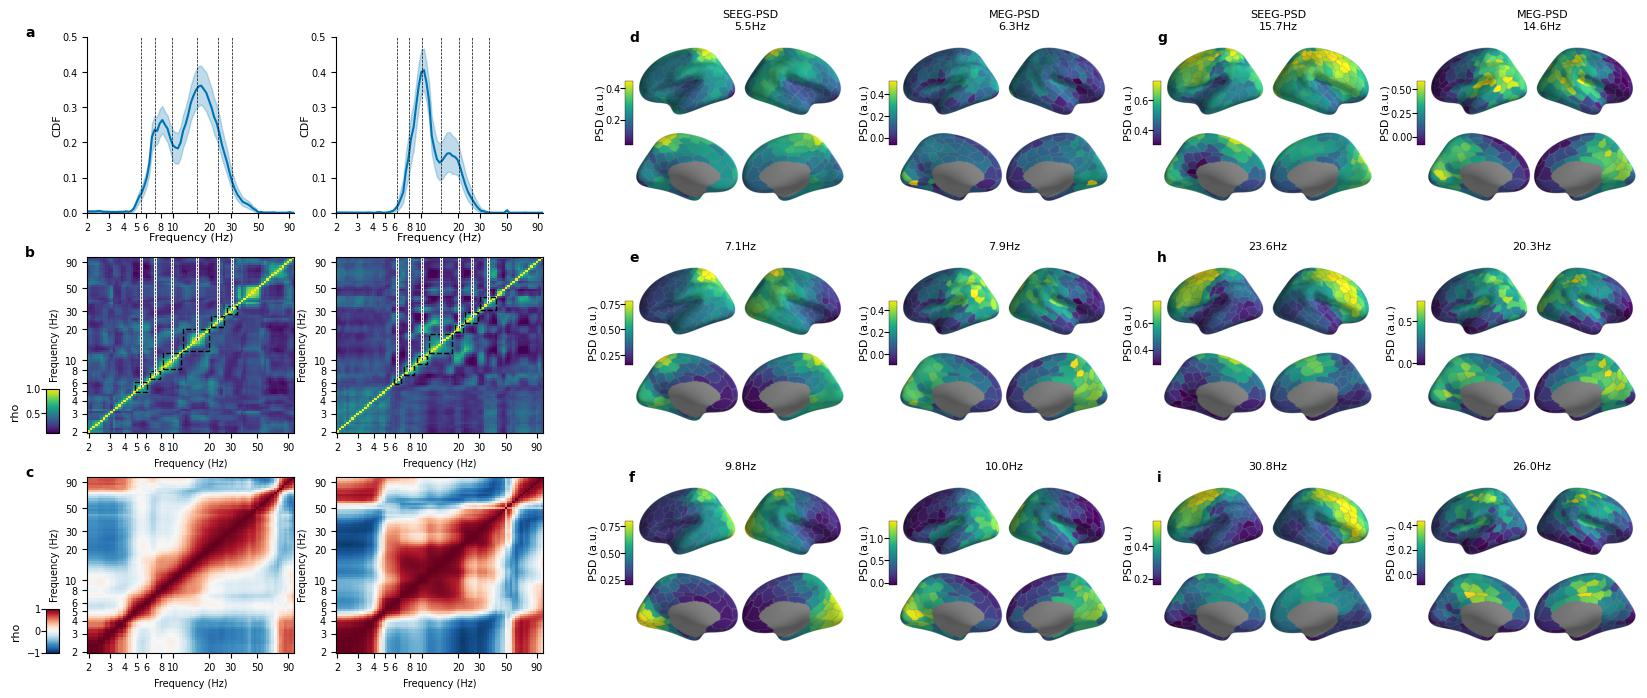

In [63]:
fig = plt.figure(figsize=(20,8))
main_spec = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1,1,1])

gs_0 = main_spec[0].subgridspec(3,2, hspace=0.25)
gs_brain_cols = main_spec[1:].subgridspec(ncols=4, nrows=3, hspace=0.25, wspace=0.25)

axes = np.empty((8,12), dtype=object)

axes[0,0] = fig.add_subplot(gs_0[0, 0])
axes[0,1] = fig.add_subplot(gs_0[0, 1])
axes[1,0] = fig.add_subplot(gs_0[1, 0])
axes[1,1] = fig.add_subplot(gs_0[1, 1])
axes[2,0] = fig.add_subplot(gs_0[2, 0])
axes[2,1] = fig.add_subplot(gs_0[2, 1])

for i,j in itertools.product(range(3), range(4)):
    brain_gs = gs_brain_cols[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc+2] = fig.add_subplot(brain_gs[nr,nc])


seeg_meg_psd_freq_cax = inset_axes(axes[2,0],
                 width="8%",  # width = 10% of parent_bbox width
                 height="25%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(-0.2, 0.0, 0.8, 1),
                 bbox_transform=axes[2,0].transAxes,
                 borderpad=0,
                 )

corr_distance_freq_cax = inset_axes(axes[1,0],
                 width="8%",  # width = 10% of parent_bbox width
                 height="25%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(-0.2, 0.0, 0.8, 1),
                 bbox_transform=axes[1,0].transAxes,
                 borderpad=0,
                 )
        
for i in range(6):   
    for type_idx, modality, mapper, data in zip(range(2), ['SEEG', 'MEG'], 
                                [seeg_communities, meg_communities],
                                [seeg_psd_known, reorder(subj_psd_foofed, yeo17_orig_ch_names, meg_parcels_annot, axis=-1).T]):
        row_idx = (i % 3)
        col_idx = (i // 3)*2 + type_idx + 1

        is_seeg = (modality == 'SEEG')
        indices = mapper[i]
        center_frequency = f_vals[indices].mean()

        values = np.nanmean(data[:, indices], axis=-1)
        cmap_name = 'viridis'
        norm_values = None
        
        if is_seeg:
            values = smooth_adjacent_values(values, counter_known, adjacency_matrix)
            values = np.clip(values, 0.0, np.nanpercentile(values, 99))  
            
        vmin = values.min()
        vmax = values.max()

        norm_values = (vmin, vmax)
        
        to_plot_axes = axes[row_idx*2:(row_idx+1)*2, col_idx*2:(col_idx+1)*2]

        draw_four_views(to_plot_axes, values, surf_parcel_names,
                        brain_3d_surfaces, cmap=cmap_name, norm_values=norm_values)

        cbar_ax = fig.axes[~0]
        
        if row_idx == 0:
            title = f'{modality}-PSD\n{round(center_frequency, 1)}Hz'
            title_x  = 1.1
        else:
            title = f'{round(center_frequency, 1)}Hz'
            title_x = 1.0
            
        to_plot_axes[0,0].set_title(title, x=title_x, y=1.05, fontsize=8)

axes[0,0].semilogx(f_vals, psd_sign_ratio_mean, color=ripples_blue)
axes[0,0].fill_between(f_vals, psd_sign_ratio_5, psd_sign_ratio_95, color=ripples_blue, alpha=0.25)

axes[0,1].semilogx(f_vals, meg_psd_sign_mean, color=ripples_blue)
axes[0,1].fill_between(f_vals, meg_psd_sign_5, meg_psd_sign_95, color=ripples_blue, alpha=0.25)

imh0 = axes[1,0].pcolormesh(f_vals, f_vals, 1 - pac_val_corr_distance, cmap='viridis', vmax=1, vmin=0.1)
axes[1,1].pcolormesh(f_vals, f_vals, 1 - meg_pac_val_corr_distance, cmap='viridis', vmax=1, vmin=0.1)

imh1 = axes[2,0].pcolormesh(f_vals, f_vals, psd_val_similarity_freq_both, cmap='RdBu_r', vmax=1, vmin=-1)
axes[2,1].pcolormesh(f_vals, f_vals, meg_psd_val_similarity_freq_both, cmap='RdBu_r', vmax=1, vmin=-1)

for comm in seeg_communities:
    center_freq = f_vals[comm].mean()
    
    s, e = f_vals[min(comm)], f_vals[max(comm)]
    
    r = plt.Rectangle([s,s], e-s, e-s, facecolor='none', edgecolor='black', ls='--')
    axes[1,0].add_patch(r)   
    
    axes[1,0].vlines([center_freq], center_freq, 100, color='white',lw=2)
    axes[1,0].vlines([center_freq], center_freq, 100, color='black', ls='--', lw=0.5)

    axes[0,0].vlines([center_freq], 0, 1, ls='--', color='black', lw=0.5)
    
for comm in meg_communities:
    center_freq = f_vals[comm].mean()
    s, e = f_vals[min(comm)], f_vals[max(comm)]
    
    r = plt.Rectangle([s,s], e-s, e-s, facecolor='none', edgecolor='black', ls='--')
    axes[1,1].add_patch(r)  
    
    axes[1,1].vlines([center_freq], center_freq, 100, color='white', lw=2)
    axes[1,1].vlines([center_freq], center_freq, 100, color='black', ls='--', lw=0.5)

    axes[0,1].vlines([center_freq], 0, 1, ls='--', color='black', lw=0.5)
  

for ax in axes[0,:2]:    
    ax.set_xscale('log')

    ax.set_xticks([2,3,4,5,6,8,10,20,30, 50, 90])
    
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.set_xlabel('Frequency (Hz)', fontsize=8, labelpad=0.0)
    ax.set_ylabel('CDF', fontsize=8, labelpad=0.0)

    ax.minorticks_off()
    ax.tick_params(labelsize=7)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(f_vals[[0,~0]])
    ax.set_ylim([0,0.5])
        
for ax in axes[1:3,:2].flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xticks([2,3,4,5,6,8,10,20,30, 50, 90])
    ax.set_yticks([2,3,4,5,6,8,10,20,30, 50, 90])
    
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.yaxis.set_minor_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    
    ax.minorticks_off()
    ax.tick_params(labelsize=7)

    ax.set_xlabel('Frequency (Hz)', fontsize=7)
    ax.set_ylabel('Frequency (Hz)', fontsize=7)
    
fig.colorbar(imh1, cax=seeg_meg_psd_freq_cax, orientation='vertical')
fig.colorbar(imh0, cax=corr_distance_freq_cax, orientation='vertical')

for ax, label in  zip(fig.axes[-12:], ['PSD (a.u.)']*12):
    ax.set_ylabel(label, fontsize=8, labelpad=0.0)
    ax.yaxis.set_label_position('left')

# for ax in fig.axes[-4:]:
#     ax.set_ylabel('pACF', fontsize=8, labelpad=0.0)

# for ax in fig.axes[-12:]:

for ax in fig.axes[-14:]:
    ax.tick_params(labelsize=7, pad=0.0)
    
seeg_meg_psd_freq_cax.yaxis.set_label_text('rho', fontsize=8)
seeg_meg_psd_freq_cax.yaxis.set_label_position('left')
seeg_meg_psd_freq_cax.yaxis.set_ticks_position('left')

corr_distance_freq_cax.yaxis.set_label_text('rho', fontsize=8)
corr_distance_freq_cax.yaxis.set_label_position('left')
corr_distance_freq_cax.yaxis.set_ticks_position('left')

ax_labels = [axes[0,0], axes[1,0], axes[2,0]]
ax_brain_labels = [axes[0,2], axes[2,2], axes[4,2], axes[0,6], axes[2,6], axes[4,6]]

for ax, label in zip(ax_labels, 
                     string.ascii_lowercase):
    ax.text(-0.3, 1, label, fontsize=10, transform=ax.transAxes, weight='bold')
    
for ax, label in zip(ax_brain_labels, 
                     string.ascii_lowercase[3:]):
    ax.text(-0.05, 1, label, fontsize=10, transform=ax.transAxes, weight='bold')
      
fig.savefig('publication_figures/figure_3_supp.png', dpi=300, bbox_inches="tight")

In [ ]:
import cv2
from utils.plot import get_img_from_fig

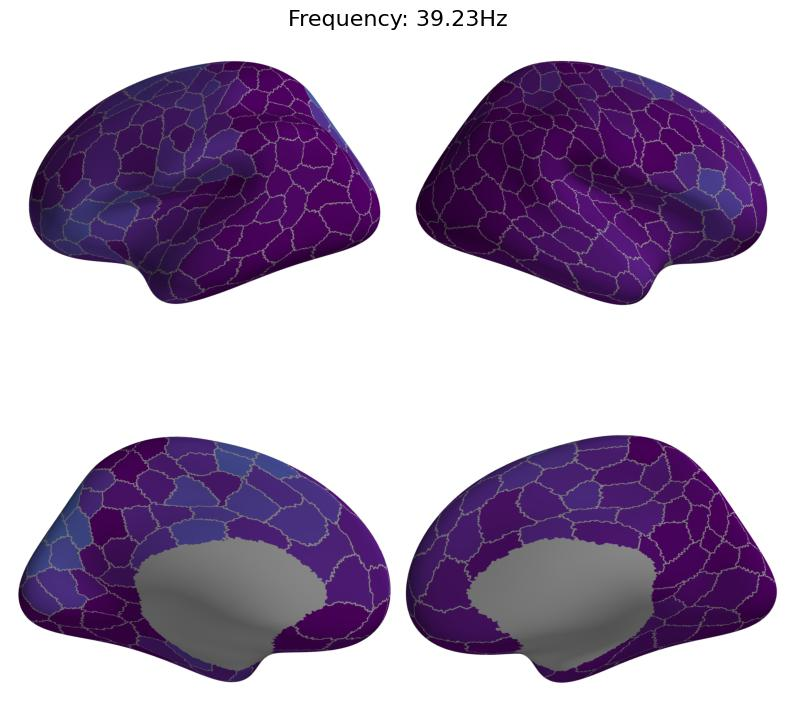

In [65]:
images_list = list()

fig, axes = plt.subplots(figsize=(10,10), ncols=2, nrows=2, gridspec_kw={'hspace': 0.0, 'wspace': 0.0})

for freq_idx, freq in enumerate(f_vals[:62]):
    values = known_pac_significant[:, freq_idx]
    values = smooth_adjacent_values(values, counter_known, adjacency_matrix)

    values = np.clip(values, 0.0, np.nanpercentile(values, 99))  

#     vmin = values.min()
#     vmax = values.max()
    vmin = 0.0
    vmax = 0.6

    norm_values = (vmin, vmax)
    
    draw_four_views(axes, values, surf_parcel_names,
                    brain_3d_surfaces, cmap='viridis', norm_values=norm_values)
    axes[0,0].set_title(f'Frequency: {round(freq, 2)}Hz', x=1, fontsize=16)
    
    
    fig_array = get_img_from_fig(fig)
    images_list.append(fig_array)
    fig.axes[~0].remove()

In [66]:
height, width, layers = images_list[0].shape
fps = 2
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') 

video = cv2.VideoWriter('pACF_movie_sign.mov', fourcc, fps, (width,height))

for image in images_list:
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    video.write(image_bgr)

cv2.destroyAllWindows()
video.release()